In [1]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 torchtext==0.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 758.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 52.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 42.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
  Attempting uninstall: torchvision
    Found existing installation: tor

In [2]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [3]:
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import os, sys, random
import pandas as pd
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt

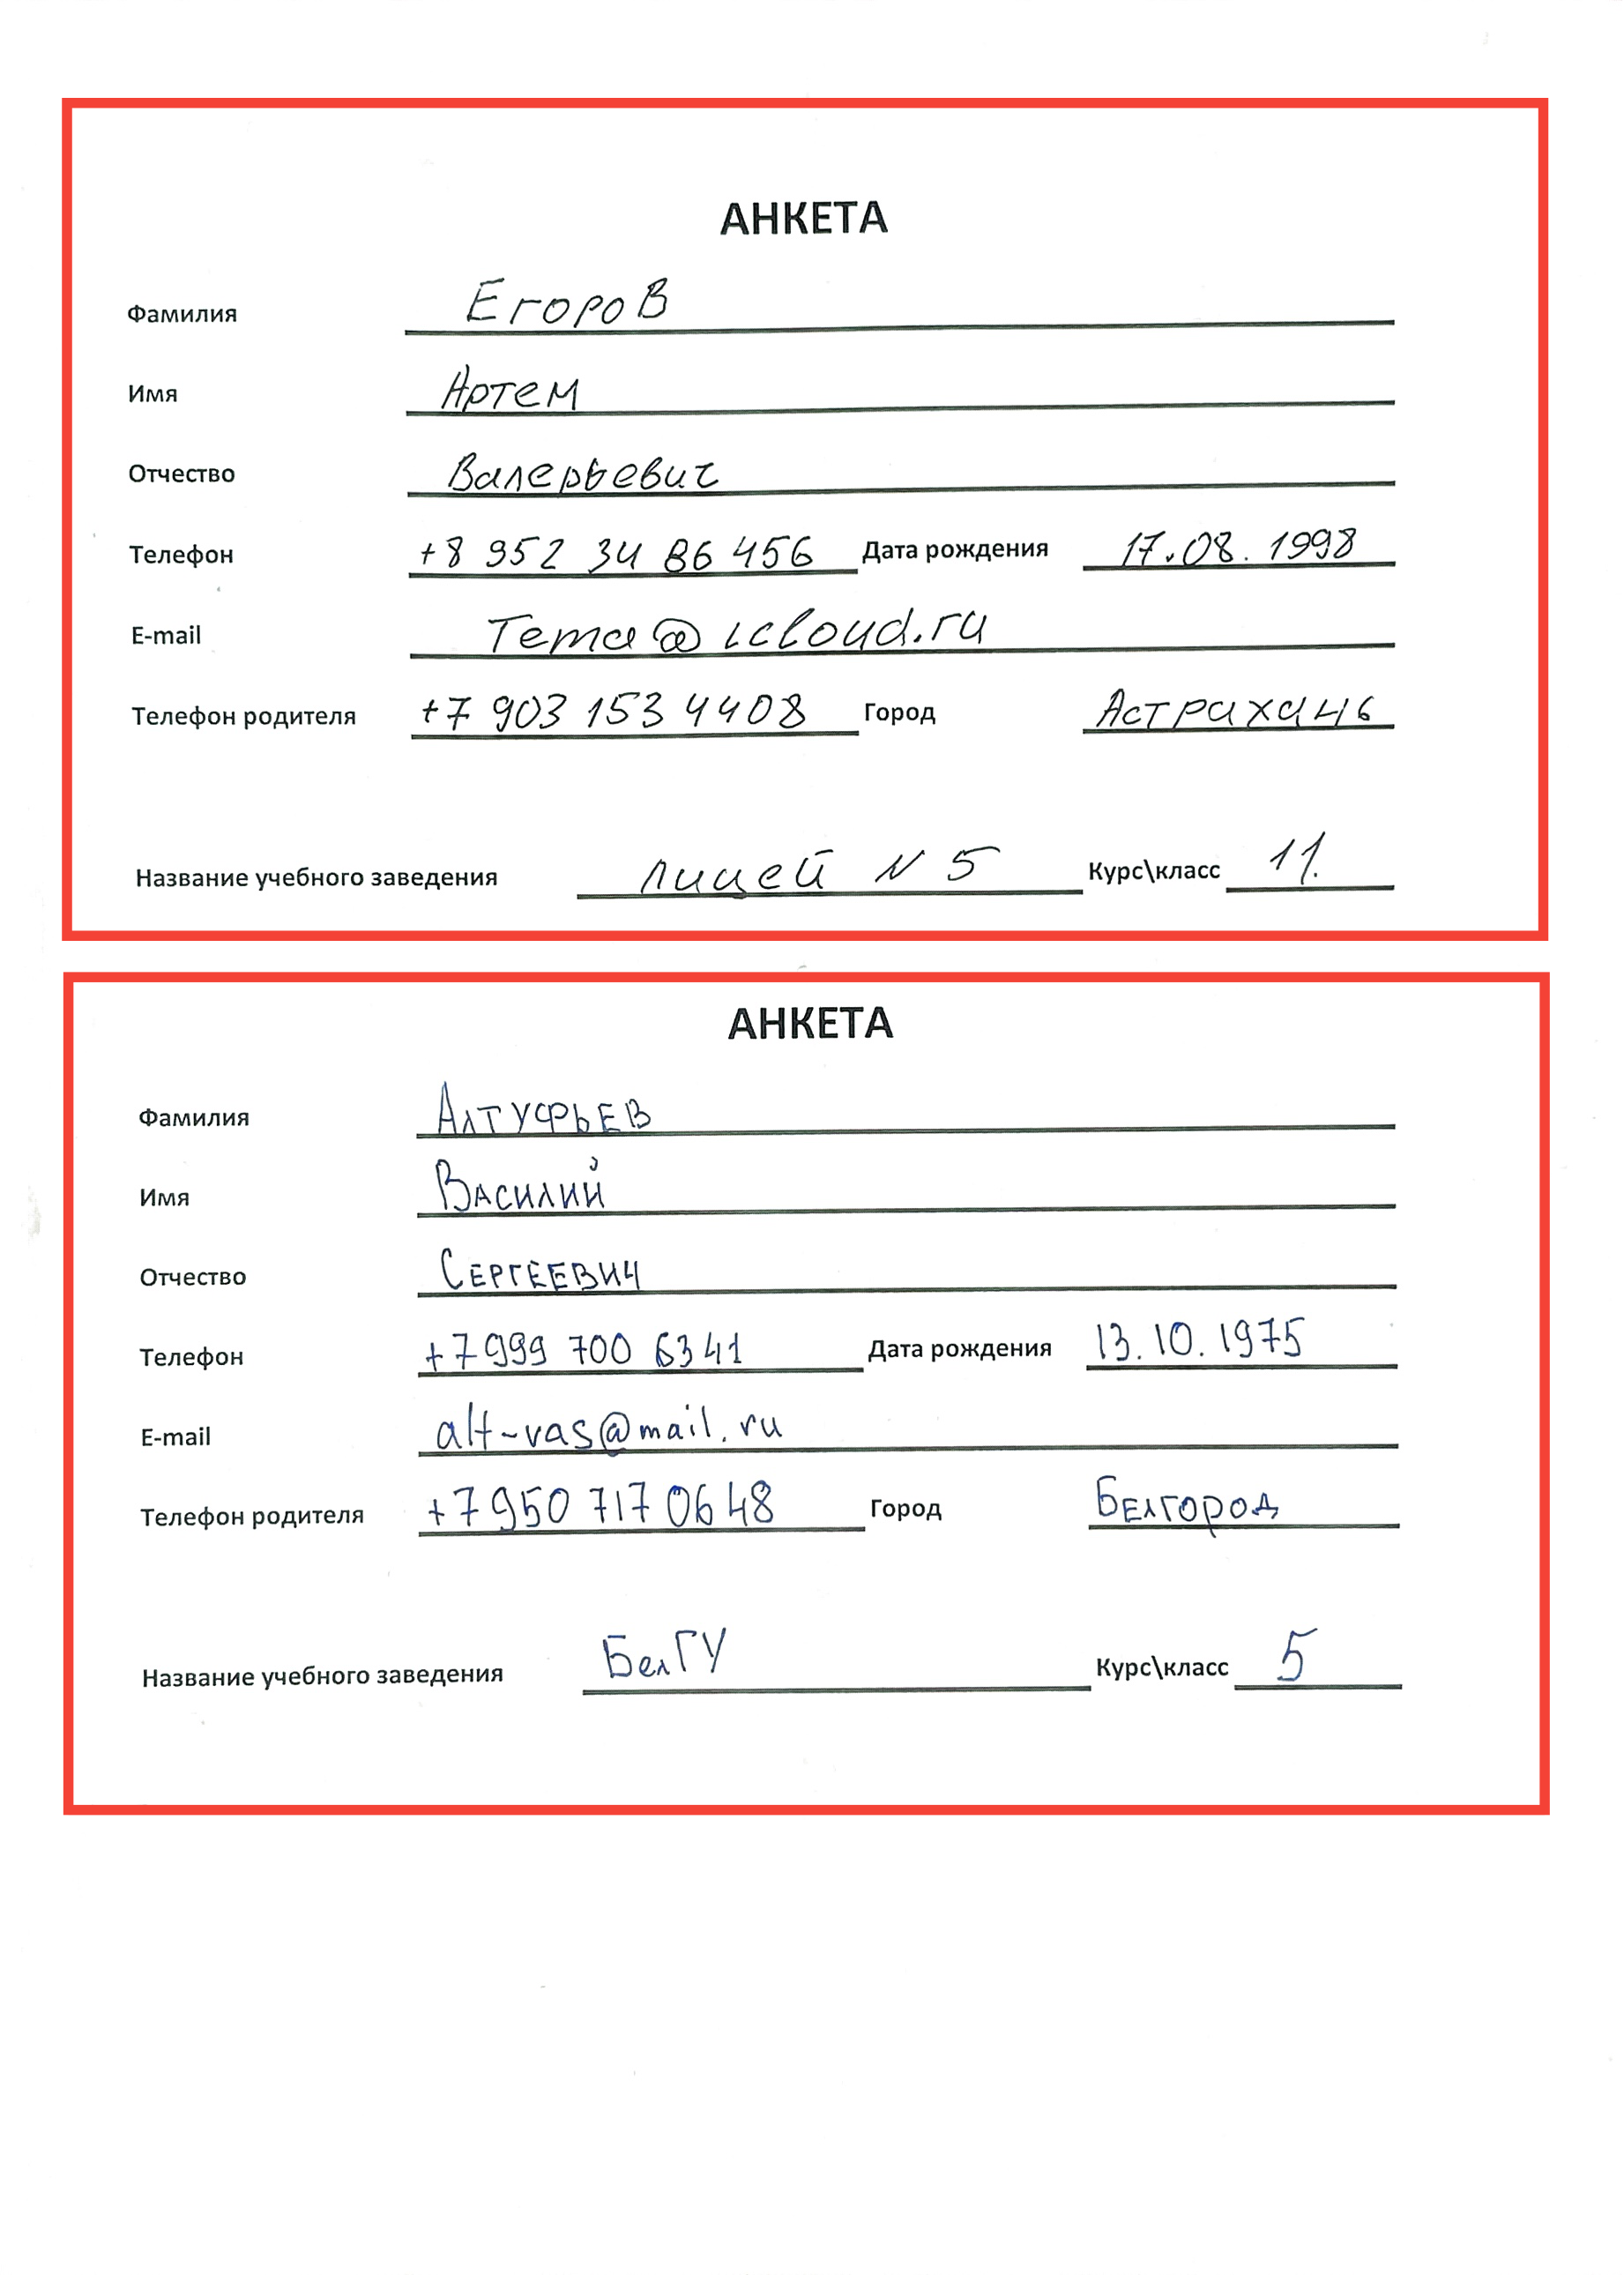

In [4]:
Image.open('/kaggle/input/questionnaires/VOC_XML/images/3b30d61e-img_39_01.png')

In [5]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.5 MB/s eta 0:00:00a 0:00:01m


In [6]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import utils
from engine import train_one_epoch, evaluate

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 4  # 3 class  + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
class VOCDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms

        # Load annotations
        annotations = glob(os.path.join(self.annotations_path, '*.xml'))
        self.data = self._load_annotations(annotations)

    def _load_annotations(self, annotations):
        data = []
        for file in annotations:
            filename = os.path.basename(file).replace('.xml', '.png')
            parsedXML = ET.parse(file)
            for node in parsedXML.getroot().iter('object'):
                fields = node.find('name').text
                xmin = int(node.find('bndbox/xmin').text)
                xmax = int(node.find('bndbox/xmax').text)
                ymin = int(node.find('bndbox/ymin').text)
                ymax = int(node.find('bndbox/ymax').text)

                row = [filename, fields, xmin, xmax, ymin, ymax]
                data.append(row)
        return pd.DataFrame(data, columns=['filename', 'fields', 'xmin', 'xmax', 'ymin', 'ymax'])

    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        img_path = os.path.join(self.images_path, record['filename'])

        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))  # Avoid returning None

        img = Image.open(img_path).convert("RGB")

        # Get bounding box coordinates and labels
        boxes = []
        labels = []
        label_map = {"Surname": 1, "Name": 2, "Phone": 3}

        xmin = record['xmin']
        xmax = record['xmax']
        ymin = record['ymin']
        ymax = record['ymax']
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[record['fields']])

        # Convert everything to a torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = T.ToTensor()(image)
        return image, target

class RandomVerticalFlip:
    def __init__(self, p=0.2):
        self.p = p

    def __call__(self, image, target):
        if torch.rand(1) < self.p:
            image = T.functional.vflip(image)
            if "boxes" in target:
                bbox = target["boxes"]
                bbox[:, [1, 3]] = image.size(1) - bbox[:, [3, 1]]
                target["boxes"] = bbox
        return image, target

def get_transform(train):
    transforms = [ToTensor()]
    if train:
        transforms.append(RandomVerticalFlip(0.2))
    return Compose(transforms)



## Загрузка Датасета

In [10]:
# Paths to images and annotations
images_path = '/kaggle/input/questionnaires/VOC_XML/images'
annotations_path = '/kaggle/input/questionnaires/VOC_XML/Annotations'

# use our dataset and defined transformations
train_dataset = VOCDataset(images_path, annotations_path, get_transform(train=True))
test_dataset = VOCDataset(images_path, annotations_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-300])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-300:])

# define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

## Обучение

In [ ]:
# Перемещение модели на нужное устройство
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Определение оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Функция сохранения модели
def save_checkpoint(epoch, model, optimizer, scheduler, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(checkpoint, path)

# Функция загрузки модели
def load_checkpoint(path, model, optimizer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']

# Функция для построения кривых потерь
def plot_metrics(metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics, label=metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


losses = []
classifier_losses = []
box_reg_losses = []
objectness_losses = []
rpn_box_reg_losses = []


num_epochs = 10
save_path = '/kaggle/working/model_checkpoint.pth'
start_epoch = 0

# Если нужно загрузить с контрольной точки
# start_epoch = load_checkpoint(save_path, model, optimizer, lr_scheduler)


for epoch in range(start_epoch, num_epochs):
    
    metric_logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=100)

    
    epoch_losses = metric_logger.meters["loss"].global_avg
    epoch_loss_classifier = metric_logger.meters["loss_classifier"].global_avg
    epoch_loss_box_reg = metric_logger.meters["loss_box_reg"].global_avg
    epoch_loss_objectness = metric_logger.meters["loss_objectness"].global_avg
    epoch_loss_rpn_box_reg = metric_logger.meters["loss_rpn_box_reg"].global_avg

    
    losses.append(epoch_losses)
    classifier_losses.append(epoch_loss_classifier)
    box_reg_losses.append(epoch_loss_box_reg)
    objectness_losses.append(epoch_loss_objectness)
    rpn_box_reg_losses.append(epoch_loss_rpn_box_reg)

    # Оценка модели на валидационной выборке
    # evaluate(model, val_loader, device=device)

    # Шаг планировщика LR
    lr_scheduler.step()

    # Сохранение контрольной точки
    save_checkpoint(epoch, model, optimizer, lr_scheduler, save_path)

Epoch: [0]  [   0/2059]  eta: 0:26:00  lr: 0.000010  loss: 0.5999 (0.5999)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0196 (0.0196)  loss_objectness: 0.1854 (0.1854)  loss_rpn_box_reg: 0.3634 (0.3634)  time: 0.7579  data: 0.1560  max mem: 3523
Epoch: [0]  [ 100/2059]  eta: 0:20:17  lr: 0.000509  loss: 0.0861 (0.1151)  loss_classifier: 0.0321 (0.0397)  loss_box_reg: 0.0268 (0.0313)  loss_objectness: 0.0095 (0.0151)  loss_rpn_box_reg: 0.0141 (0.0290)  time: 0.6243  data: 0.0125  max mem: 3523
Epoch: [0]  [ 200/2059]  eta: 0:19:18  lr: 0.001009  loss: 0.1022 (0.1140)  loss_classifier: 0.0362 (0.0411)  loss_box_reg: 0.0271 (0.0306)  loss_objectness: 0.0102 (0.0155)  loss_rpn_box_reg: 0.0180 (0.0269)  time: 0.6395  data: 0.0249  max mem: 3523
Epoch: [0]  [ 300/2059]  eta: 0:18:10  lr: 0.001508  loss: 0.1003 (0.1126)  loss_classifier: 0.0395 (0.0408)  loss_box_reg: 0.0247 (0.0300)  loss_objectness: 0.0063 (0.0146)  loss_rpn_box_reg: 0.0215 (0.0272)  time: 0.6491  data: 0.0290  max me

In [13]:
def save_trained_model(model, path):
    torch.save(model.state_dict(), path)

trained_model_path = '/kaggle/working/trained_model.pth'

save_trained_model(model, trained_model_path)
               

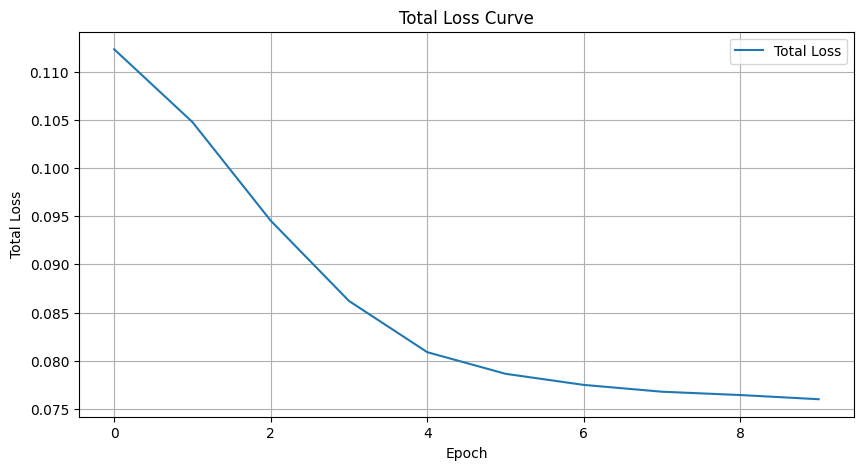

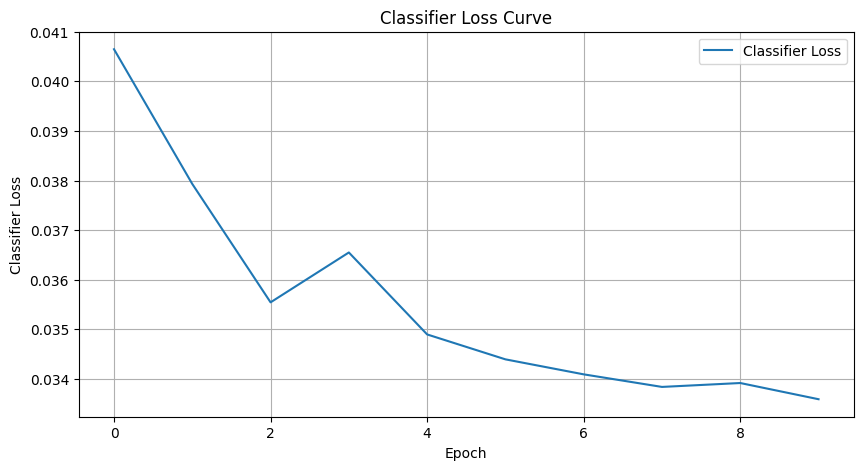

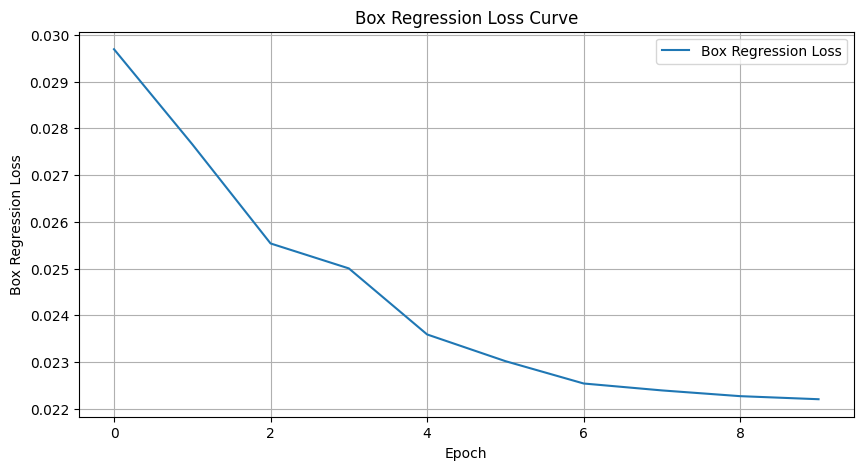

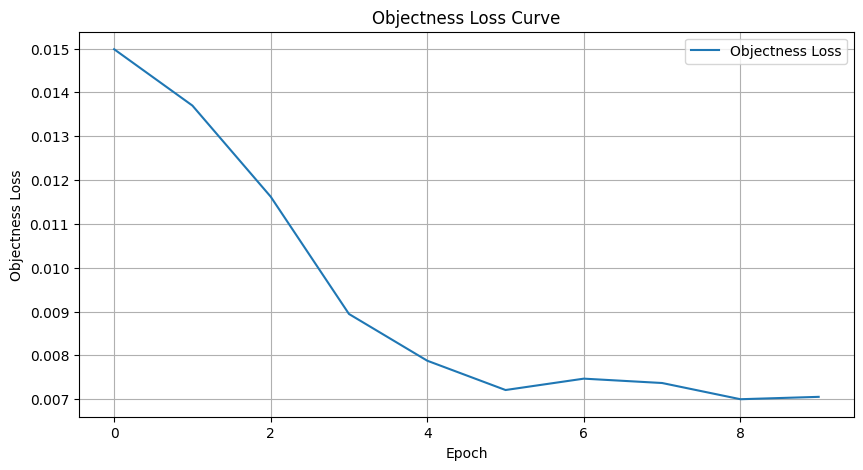

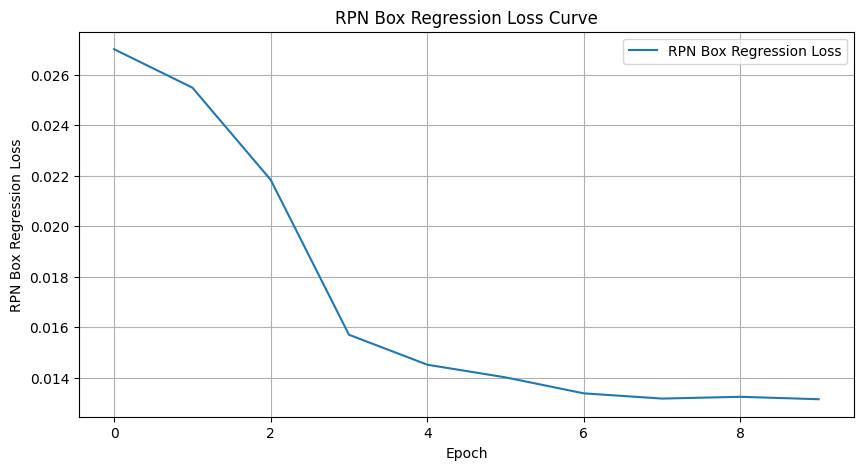

In [14]:
# Построение кривых потерь после обучения
plot_metrics(losses, "Total Loss")
plot_metrics(classifier_losses, "Classifier Loss")
plot_metrics(box_reg_losses, "Box Regression Loss")
plot_metrics(objectness_losses, "Objectness Loss")
plot_metrics(rpn_box_reg_losses, "RPN Box Regression Loss")

In [48]:
model_path = '/kaggle/input/field_detector/pytorch/default/1/trained_model.pth'

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 4  # 3 класса + фон
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # Установить режим предсказания
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [49]:
COLORS = {
    1: "red",    # "Surname"
    2: "blue",   # "Name"
    3: "green",  # "Phone"
}


CLASS_NAMES = {
    1: "Surname",
    2: "Name",
    3: "Phone",
}


def plot_image_with_boxes(img, boxes, labels):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        label = labels[i]
        color = COLORS.get(label, "black")  # Получаем цвет для класса или черный по умолчанию

        draw.rectangle(((xmin, ymin), (xmax, ymax)), outline=color, width=3)
        text = CLASS_NAMES.get(label, "Unknown")
        text_bbox = draw.textbbox((xmin, ymin), text, font=font)  # Используем textbbox для получения размеров текста
        draw.rectangle(text_bbox, fill=color)  # Заполняем фон для текста
        draw.text((xmin, ymin), text, fill="white", font=font)  # Рисуем текст на изображении
    
    return img


def predict_and_plot_random(test_dataset, model, device, num_images=5):
    model.eval()  

    
    random_indices = random.sample(range(len(test_dataset)), num_images)

    for i in random_indices:
        img, _ = test_dataset[i]
        img = img.to(device).unsqueeze(0)  

        with torch.no_grad():
            prediction = model(img)

        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  
        img = (img * 255).astype(np.uint8)  
        img = Image.fromarray(img)  

        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        img_with_boxes = plot_image_with_boxes(img, boxes, labels)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_with_boxes)
        plt.axis('off')
        plt.show()




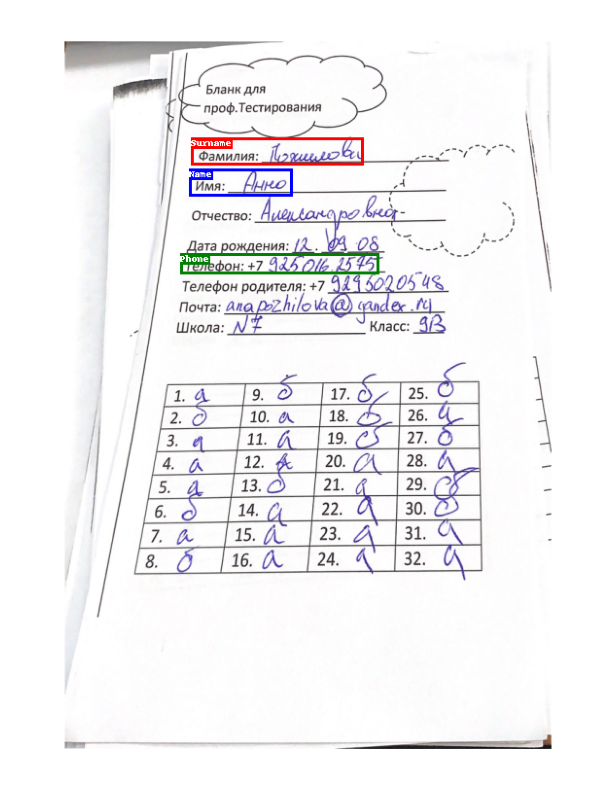

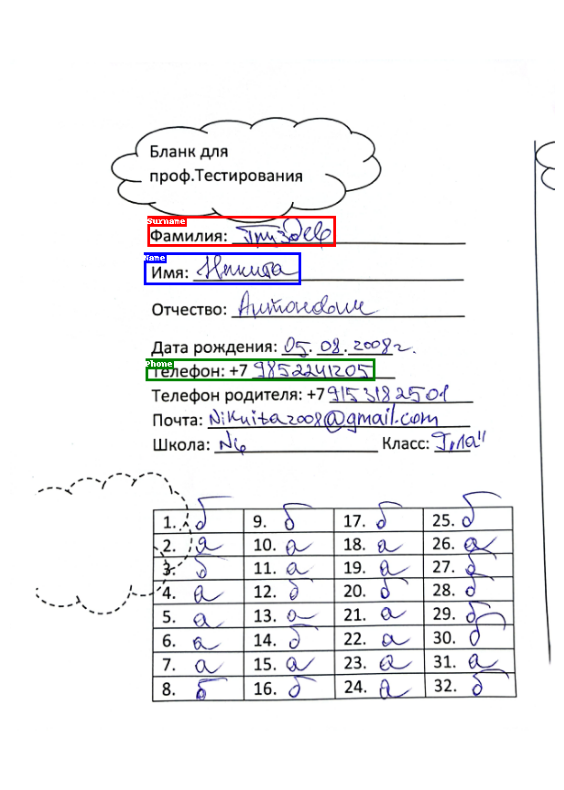

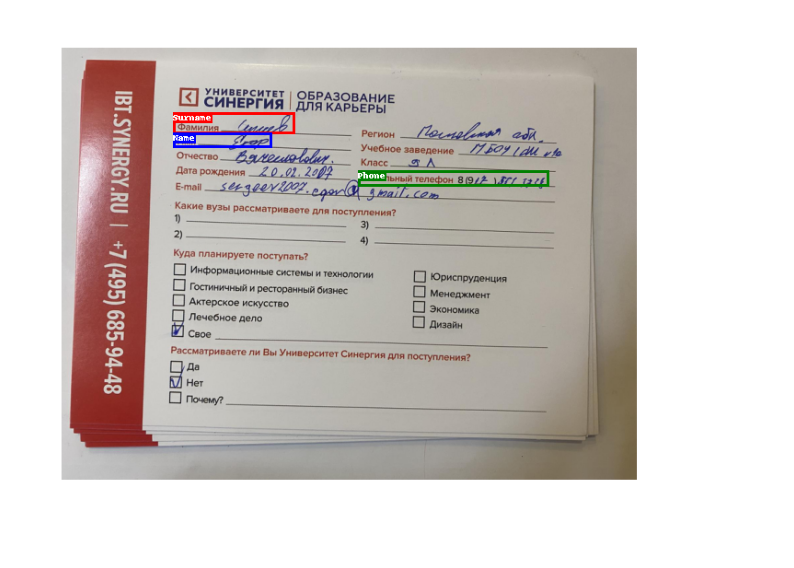

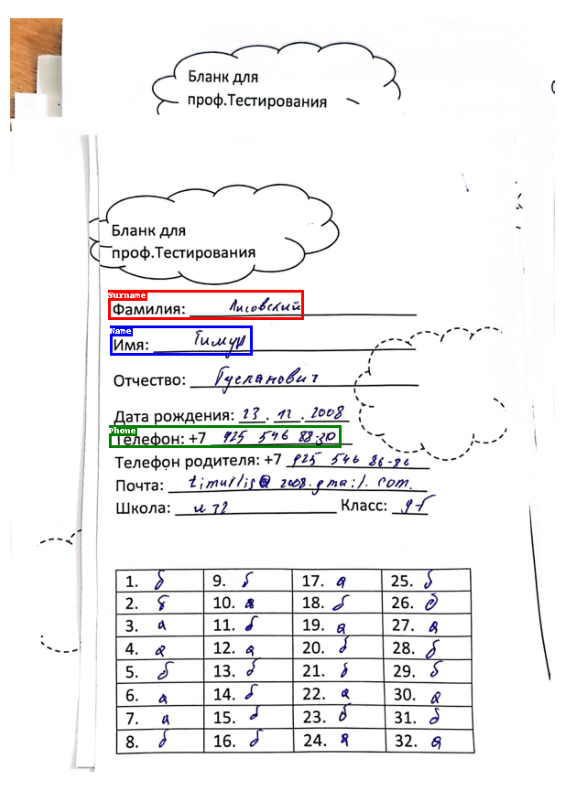

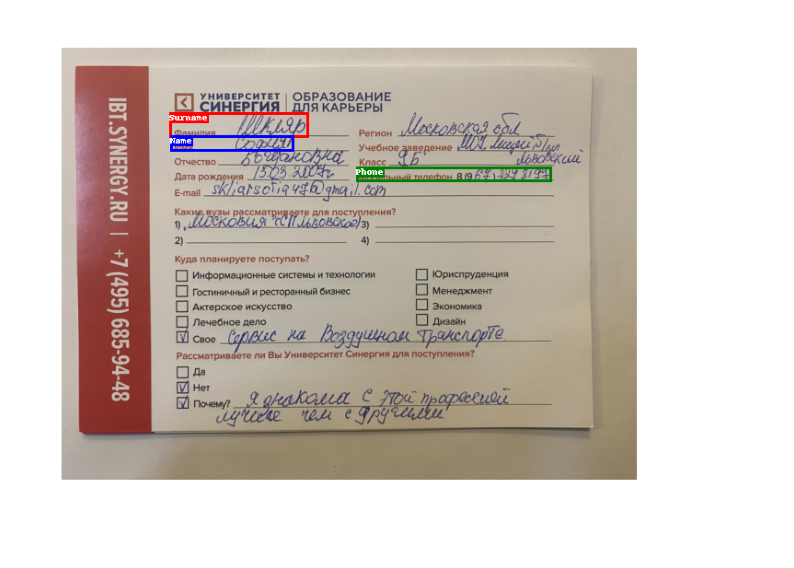

In [50]:
predict_and_plot_random(test_dataset, model, device, num_images=5)